In [2]:
import matplotlib
import pandas as pd
import re
%matplotlib inline
import matplotlib.pyplot as plt
import datetime
import matplotlib.dates as mdates

#Read in the csv. Throw out bad lines-- there are just a few of the 9000-- and suppress warnings.
filepath = "./emerald_equity_hpd_violations.csv"
df = pd.read_csv(filepath, error_bad_lines=False, warn_bad_lines=False)
#Wrap text, because I want to see those commplaints in their entirety
pd.set_option('display.max_colwidth', -1)



In [3]:
harlem_hpd_df = pd.read_csv("./hpd_violations_east_harlem.csv")
ee_hpd_df = pd.read_csv("./hpd_violations_ee.csv")


In [8]:
#Change index to datetime
ee_hpd_df['date']= pd.to_datetime(ee_hpd_df['date'], infer_datetime_format=True, errors='coerce')
ee_hpd_df = ee_hpd_df.set_index(pd.DatetimeIndex(ee_hpd_df['date'].fillna(method='bfill')))
harlem_hpd_df['date']= pd.to_datetime(harlem_hpd_df['date'], infer_datetime_format=True, errors='coerce')
harlem_hpd_df = harlem_hpd_df.set_index(pd.DatetimeIndex(harlem_hpd_df['date'].fillna(method='bfill')))

In [9]:
#These are the things I want to pay attention to
ee_hpd_df['Mold'] = ee_hpd_df['descript'].str.contains('MOLD|MILDEW').astype(int)
ee_hpd_df['Gas'] = ee_hpd_df['descript'].str.contains('GAS').astype(int)
ee_hpd_df['Heat'] = ee_hpd_df['descript'].str.contains('HEAT').astype(int)
ee_hpd_df['Pests'] = ee_hpd_df['descript'].str.contains('PEST|RODENT|ROACH|MICE|VIOLATIONS').astype(int)
ee_hpd_df['Lead'] = ee_hpd_df['descript'].str.contains('LEAD|lead').astype(int)

In [10]:
ee_hpd_df["2000":][['Lead', 'Mold', 'Gas', 'Heat', 'Pests']].resample('M').sum().reset_index().to_csv("hpd_categorical.csv")

In [11]:
filepath2 = "./emerald_equity_dob_complaints.csv"
df_dob_ee = pd.read_csv(filepath2)
df_dob_harlem = pd.read_csv('east_harlem_dob_complaints.csv', low_memory=False)

#Just pay attention to the first instance of a complaint
df_dob_ee['inspectiondate']= pd.to_datetime(df_dob_ee['inspectiondate'], infer_datetime_format=True, errors='ignore')
df_dob_ee.drop_duplicates(subset=['complaintnumber'], keep='first',inplace=True)
df_dob_ee = df_dob_ee.set_index(pd.DatetimeIndex(df_dob_ee['inspectiondate'].fillna(method='ffill')))
df_dob_ee = df_dob_ee.groupby('inspectiondate')['complaintcategory'].value_counts().unstack().fillna(0)

df_dob_harlem['inspectiondate'] = pd.to_datetime(df_dob_harlem['inspectiondate'], infer_datetime_format=True, errors='coerce')
df_dob_harlem.drop_duplicates(subset=['complaintnumber'], keep='first',inplace=True)
df_dob_harlem = df_dob_harlem.set_index(pd.DatetimeIndex(df_dob_harlem['inspectiondate'].fillna(method='ffill')))
df_dob_harlem = df_dob_harlem.groupby('inspectiondate')['complaintcategory'].value_counts().unstack().fillna(0)


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: 'inspectiondate' is both a column name and an index level.
Defaulting to column but this will raise an ambiguity error in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: 'inspectiondate' is both a column name and an index level.
Defaulting to column but this will raise an ambiguity error in a future version
  


In [12]:
#Sum all of the columns: for this part, we do not care about types of DOB complaints.
df_dob_harlem['harlem_total'] = df_dob_harlem.sum(axis=1)

#sum up the columns for the other DF
df_dob_ee['emerald_equity_total'] = df_dob_ee.sum(axis=1)

In [13]:
#GET THE PER-UNIT NUMBER
df_dob_ee['Emerald_Equity_avg']=df_dob_ee['emerald_equity_total']/1449
df_dob_harlem['East_Harlem_avg']=df_dob_harlem['harlem_total']/51170

In [16]:
#JOIN THEM TOGETHER?
merge=pd.merge(df_dob_ee,df_dob_harlem, how='left', left_index=True, right_index=True)

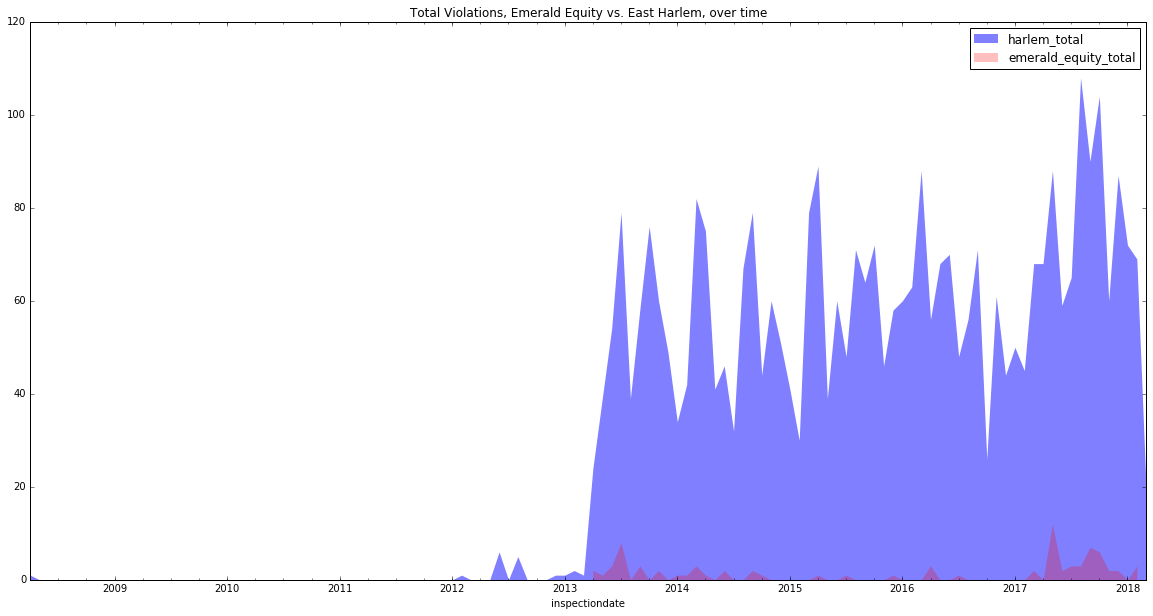

In [15]:

ax = df_dob_harlem.resample('M').sum().plot(kind='area', y='harlem_total', figsize = (20, 10), legend=True, linewidth=0, color='blue', alpha=.5)
df_dob_ee.resample('M').sum().plot(kind='area', y='emerald_equity_total', figsize = (20, 10), legend=True, linewidth=0, color='red', alpha=.25, ax=ax)

plt.savefig("DOB_overtime_tot.png")
plt.title("Total Violations, Emerald Equity vs. East Harlem, over time")

In [30]:
pd.set_option('display.float_format', lambda x: '%.9f' % x)
merge[['East_Harlem_avg', 'harlem_total', 'Emerald_Equity_avg', 'emerald_equity_total']].to_csv("combined_dob.csv")

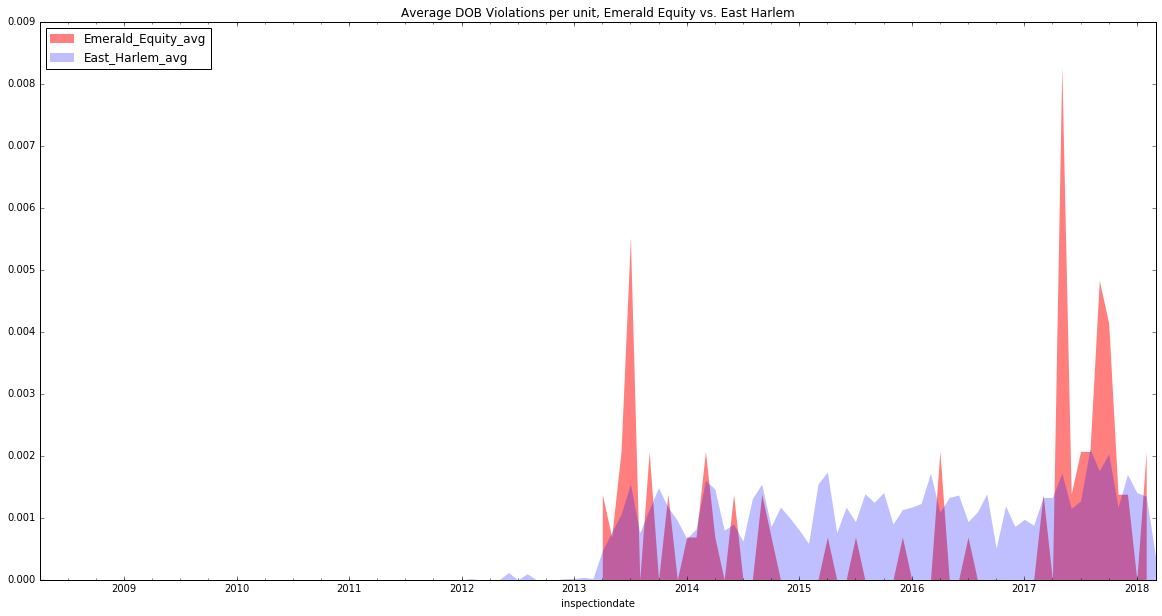

In [52]:
#This does not include duplicate complaint numbers:
#so for 1 complaint number with rows ACTIVE, ACTIVE, ACTIVE, CLOSED it will only count as 1.
#1 month sum

ax = df_dob_ee.resample('M').sum().plot(kind='area',y='Emerald_Equity_avg', figsize = (20, 10), legend=True, linewidth=0, color='red', alpha=.5)
df_dob_harlem.resample('M').sum().plot(kind='area',y='East_Harlem_avg', figsize = (20, 10), legend=True, linewidth=0, color='blue', alpha=.25, ax=ax)
plt.savefig("DOB_overtime_avg.png")
plt.title("Average DOB Violations per unit, Emerald Equity vs. East Harlem")

df_dob_harlem = df_dob_harlem[['harlem_total','East_Harlem_avg']]
df_dob_ee = df_dob_ee[['emerald_equity_total','Emerald_Equity_avg']]

merge=pd.merge(df_dob_harlem,df_dob_ee, how='inner', left_index=True, right_index=True)
merge.to_csv("combined_dob.csv")

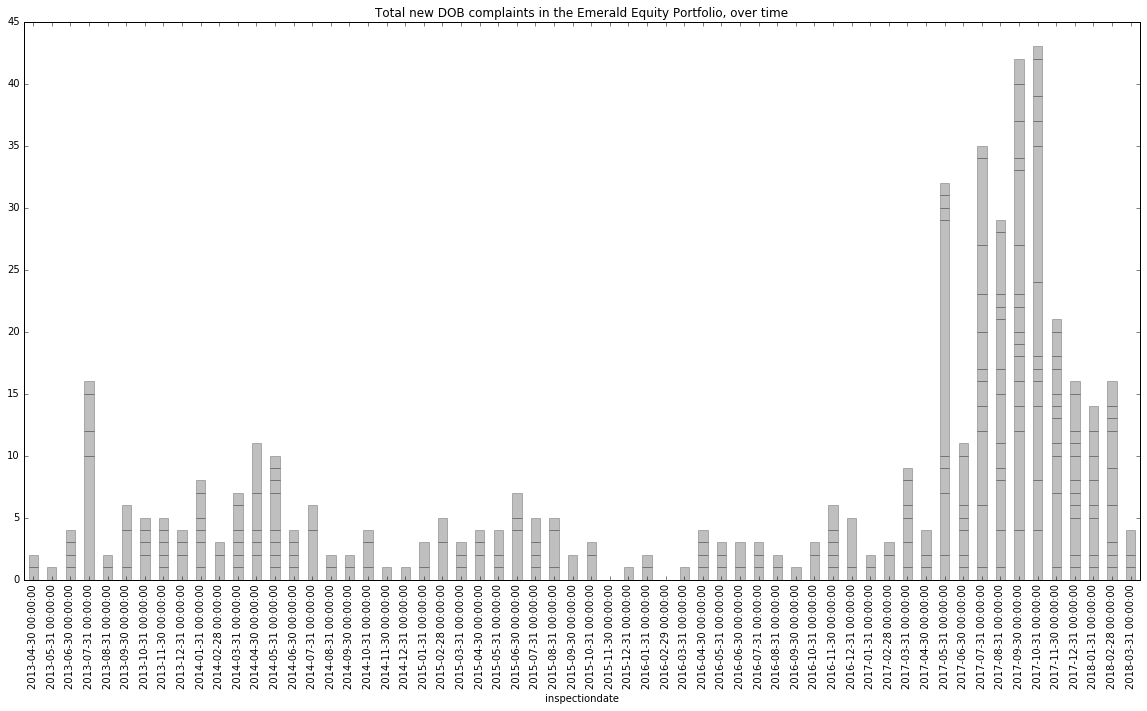

In [75]:
#This counts all violations, regardless of number of times inspected/reupped/closed. 1 row = 1 inspection
df_dob = pd.read_csv(filepath2)
df_dob['inspectiondate']= pd.to_datetime(df_dob['inspectiondate'], infer_datetime_format=True, errors='ignore')
df_dob = df_dob.groupby('inspectiondate')['complaintcategory'].value_counts().unstack().fillna(0)
df_dob.resample('M').sum().plot(kind='bar', stacked=True, figsize = (20, 10), legend=False, linewidth=.5, color='grey', alpha=.5)
plt.title("Total new DOB complaints in the Emerald Equity Portfolio, over time")
plt.savefig("DOB_overtime.png")


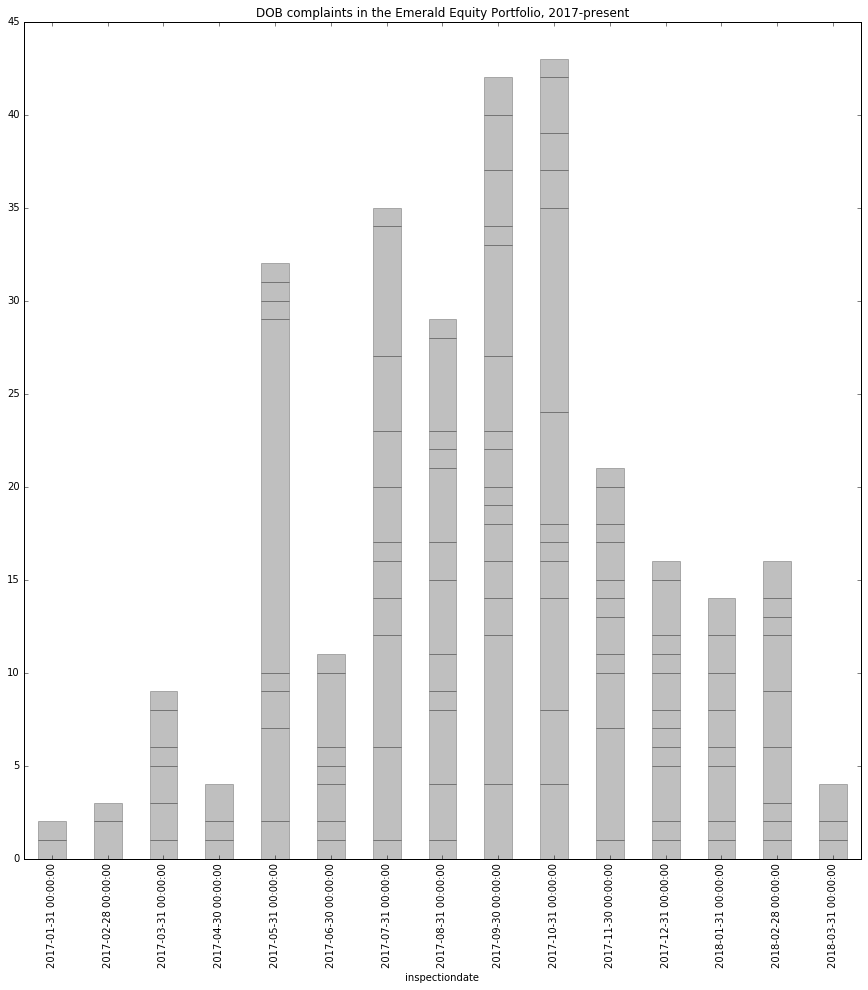

In [76]:
#This also counts repeated complaint numbers.

df_dob["2017":].resample('M').sum().plot(kind='bar', stacked=True, figsize = (15, 15), legend=False, linewidth=.5, color='grey',alpha=.5)
plt.title("DOB complaints in the Emerald Equity Portfolio, 2017-present")
plt.savefig("DOB_overtime_zoom.png")

In [7]:
import pandas as pd
harlem_hpd_df = pd.read_csv("./hpd_violations_east_harlem.csv")
ee_hpd_df = pd.read_csv("./hpd_violations_ee.csv")

ee_hpd_complaints = pd.read_csv('./hpd_complaints_ee.csv')
harlem_hpd_complaints = pd.read_csv('./hpd_complaints_harlem.csv')
harlem_hpd_complaints.columns

Index(['bbl', 'lat', 'lng', 'complaintid', 'statusdate', 'units'], dtype='object')

In [8]:
ee_hpd_bbl = ee_hpd_df.join(ee_hpd_complaints, rsuffix='comp_')
harlem_hpd_bbl = harlem_hpd_df.join(harlem_hpd_complaints, rsuffix='comp_')

ee_hpd_bbl.drop_duplicates(subset=['bbl'], keep='first',inplace=True)
harlem_hpd_bbl.drop_duplicates(subset=['bbl'], keep='first',inplace=True)


In [9]:
# Change the date to datetime, and set it as the index
#drop all duplicate violationid's. This would skew the results heavily in favor of our story.
ee_hpd_df['date']= pd.to_datetime(ee_hpd_df['date'], infer_datetime_format=True, errors='ignore')
ee_hpd_df.set_index('date', inplace=True)
ee_hpd_df.drop_duplicates(subset=['violationid'], keep='first',inplace=True)

harlem_hpd_df['date']= pd.to_datetime(harlem_hpd_df['date'], infer_datetime_format=True, errors='ignore')
harlem_hpd_df.set_index('date', inplace=True)
harlem_hpd_df.drop_duplicates(subset=['violationid'], keep='first',inplace=True)


In [10]:
# Change the date to datetime, and set it as the index, drop duplicate violation IDs
ee_hpd_complaints['date']= pd.to_datetime(ee_hpd_complaints['statusdate'], infer_datetime_format=True, errors='ignore')
ee_hpd_complaints.set_index('statusdate', inplace=True)
ee_hpd_complaints.drop_duplicates(subset=['complaintid'], keep='first',inplace=True)

harlem_hpd_complaints['date']= pd.to_datetime(harlem_hpd_complaints['statusdate'], infer_datetime_format=True, errors='ignore')
harlem_hpd_complaints.set_index('date', inplace=True)
harlem_hpd_complaints.drop_duplicates(subset=['complaintid'], keep='first',inplace=True)

##DUMMIFY VIOLATIONID, JOIN THE VIOLATIONS

ee_hpd_df['count'] = 1
ee_hpd_complaints['count']=1
ee_hpd_complaints=ee_hpd_complaints.join(ee_hpd_df, how='outer',rsuffix='viol_')

harlem_hpd_df['count'] = 1
harlem_hpd_complaints['count']=1
harlem_hpd_complaints=harlem_hpd_complaints.join(harlem_hpd_df, how='outer',rsuffix='viol_')

In [11]:
## GET THE COMPLAINTS+VIOLATIONS BY UNIT, NOT BY BUILDING!
harlem_hpd_complaints = harlem_hpd_complaints.fillna(0)
harlem_hpd_complaints['count_viol_comp'] = (harlem_hpd_complaints['count']+harlem_hpd_complaints['countviol_'])/51170


## Total residential units in East Harlem: 51170
## Total residential units in EE portfolio: 1449
ee_hpd_complaints = ee_hpd_complaints.fillna(0)
ee_hpd_complaints['count_viol_comp'] = (ee_hpd_complaints['count']+ee_hpd_complaints['countviol_'])/1449


In [12]:
ax = ee_hpd_complaints["2005":]['count_viol_comp'].resample('M').sum().plot(kind='area', color='green',legend=True, stacked=True, alpha=.5)

harlem_hpd_complaints["2005":]['count_viol_comp'].resample('M').sum().plot(kind='area', stacked=True, color = 'red', figsize = (30,10), legend=True, ax=ax,alpha=.5)
plt.title("HPD Violations and Complaints PER APARTMENT in East Harlem and Emerald Equity Over Time")

NameError: name 'plt' is not defined

In [ ]:
harlem_hpd_df['count'] = 1

harlem_hpd_complaints=harlem_hpd_complaints.join(harlem_hpd_df, how='outer',rsuffix='viol_')
harlem_hpd_complaints.columns
harlem_hpd_complaints['comp_viol_count'] = harlem_hpd_complaints['count']+ harlem_hpd_complaints['viol_count']